# Analysis

We are goint to start with analysing the data to see the numbers and figures followed by cleaning the data to prepare word clouds.

In [ ]:
# Upload your Kaggle API in order to download the required dataset.
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

In [2]:
# Preparing the API for downloading
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!pip show kaggle

Name: kaggle
Version: 1.5.6
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: requests, python-dateutil, python-slugify, certifi, tqdm, urllib3, six
Required-by: 


In [4]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 85.8MB/s]


In [5]:
!unzip /content/twitter-airline-sentiment.zip

Archive:  /content/twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [6]:
#importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
#reading the data
data=pd.read_csv('/content/Tweets.csv')

In [8]:
#checking the shape of the data
data.shape

(14640, 15)

In [9]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's know more about the data using `data.describe`.

In [10]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


Checking for the null values. Some rows like `negativereason_confidence` mostly consists of empty rows, imputing them will not help. So we will drop these columns later.

In [11]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Let's see how sentiments are distributed that is number of samples per sentiment.

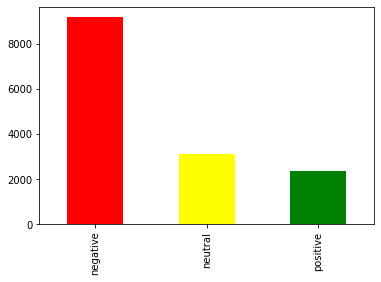

In [12]:
data['airline_sentiment'].value_counts().plot(kind='bar', color=['red','yellow','green'])

Negative sentiments samples are much more than the negative and positive sentiments. This indicates at the imablanced data. 

Let's see the number of samples for all the airlines.

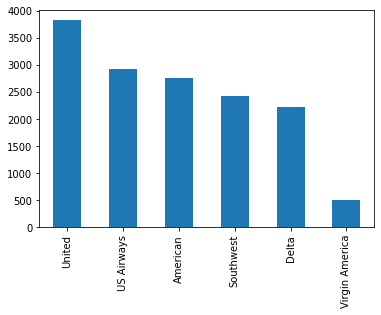

In [13]:
data['airline'].value_counts().plot(kind='bar')

People have tweeted the most for **United** followed by **US Airways**. We'll see if these tweets were postive, negative or neutral.

# Sentiments per airline

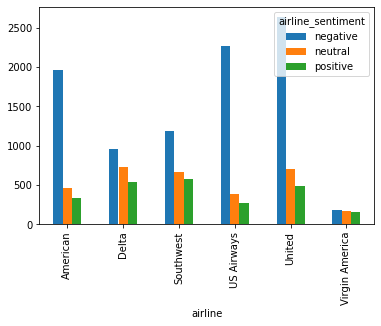

In [14]:
pd.crosstab(data['airline'],data['airline_sentiment']).plot(kind='bar')

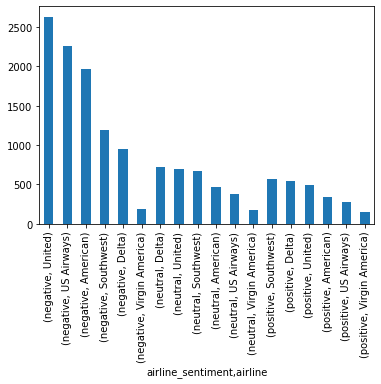

In [15]:
data['airline'].groupby(data['airline_sentiment']).value_counts().plot(kind='bar')

Now we will see how individual sentiments are distrubuted.

# Positive Sentiments

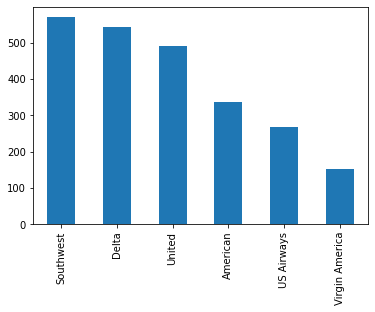

In [16]:
data[data['airline_sentiment']== 'positive'].airline.value_counts().plot(kind='bar')

# Negative Sentiments

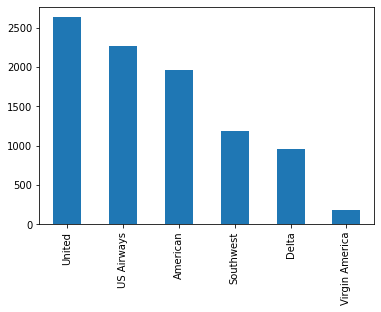

In [17]:
data[data['airline_sentiment']== 'negative'].airline.value_counts().plot(kind='bar')

# Neutral Sentiments

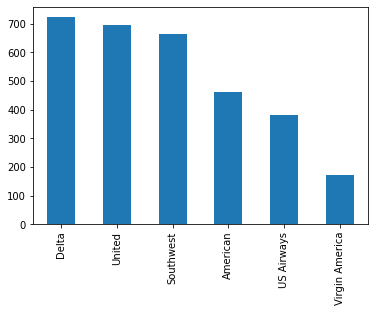

In [18]:
data[data['airline_sentiment']== 'neutral'].airline.value_counts().plot(kind='bar')

So clearly people are unahppy with **United**. Most negative tweets are for united.

**Southwest** has done a good job in serving people and hence it got most positive tweets.

Whereas **Virgin America** is stable or (least popular?) with balances negative, positive and neutral tweets.

We will now visualize the negative reasons for negative sentiments.

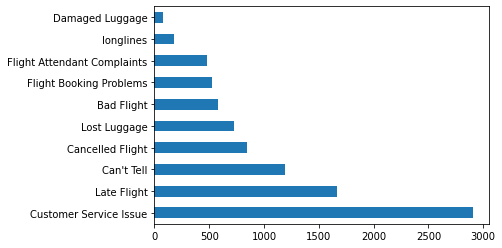

In [19]:
data['negativereason'].value_counts().plot(kind='barh')

So mostly, **Customer Service Issue** made people unhappy. If airlines want to do better they should focus on Customer Service.

Negative reason per airline

In [20]:
pd.crosstab(data['airline'], data['negativereason'])

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


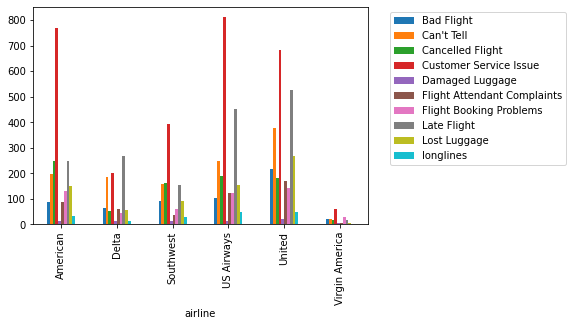

In [21]:
pd.crosstab(data['airline'], data['negativereason']).plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


**American** is guilty of the worst **Customer Service Issue**. Remebering **United** got the most negative sentiments, the reason for that seems to be the same i.e. **Customer Service Issue** followed by **Late Flight**.

Visualizing the correlation in the data

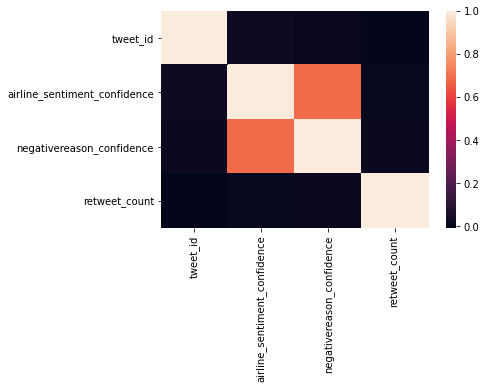

In [22]:
sns.heatmap(data.corr())

# Preprocessing

We are going to pick  `'airline_sentiment','text'` rows for our task.

In [23]:
df=data[['airline_sentiment','text']]

In [24]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Since the data is collected from twitter it is obvious to find links and mentions in the data which are not helpful in the analysis so we will remove them. 

For preprocessing the text we will remove all the

- stopwords
- punctuations
- links 
- mentions(@)

We will also perform stemming with the help of `nltk` library.

In [25]:
# Preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')
from nltk import word_tokenize
import regex as re
import nltk
snow=nltk.stem.SnowballStemmer('english')

def preprocess(doc):
  doc=re.sub('@\w+'," ",str(doc))
  doc=re.sub('#\w+'," ",str(doc))
  doc=re.sub('http\S+'," ",str(doc))
  doc=re.sub('[^\w\s]'," ",str(doc)) 
  doc=re.sub('[^a-zA-Z]'," ",str(doc))
  tokens=word_tokenize(doc)
  word=[snow.stem(word) for word in tokens]
  word=[word for word in tokens if word not in stop]
  word = [w.lower() for w in word]
  words='  '.join(word)
  return words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
df.text.apply(preprocess)

0                                               what  said
1              plus  added  commercials  experience  tacky
2        i  today  must  mean  i  need  take  another  ...
3        really  aggressive  blast  obnoxious  entertai...
4                                  really  big  bad  thing
                               ...                        
14635               thank  got  different  flight  chicago
14636    leaving  minutes  late  flight  no  warnings  ...
14637                    please  bring  american  airlines
14638    money  change  flight  answer  phones  any  su...
14639    ppl  need  know  many  seats  next  flight  pl...
Name: text, Length: 14640, dtype: object

In [27]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Let's plot the wordcloud and see how the words are distributed and how the overall data looks like.

In [28]:
from wordcloud import WordCloud

In [29]:
def make_wcd(df):
  df.text = df.text.astype(str)
  all_words = ' '.join(text for text in df.text)

  wordcloud_obj = WordCloud(width= 800,
                            height= 500, 
                            max_font_size= 110, 
                            collocations= False).generate(all_words)

  plt.figure(figsize=(15,10))
  plt.imshow(wordcloud_obj, interpolation= "bilinear")
  plt.axis("off")
  plt.show()


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


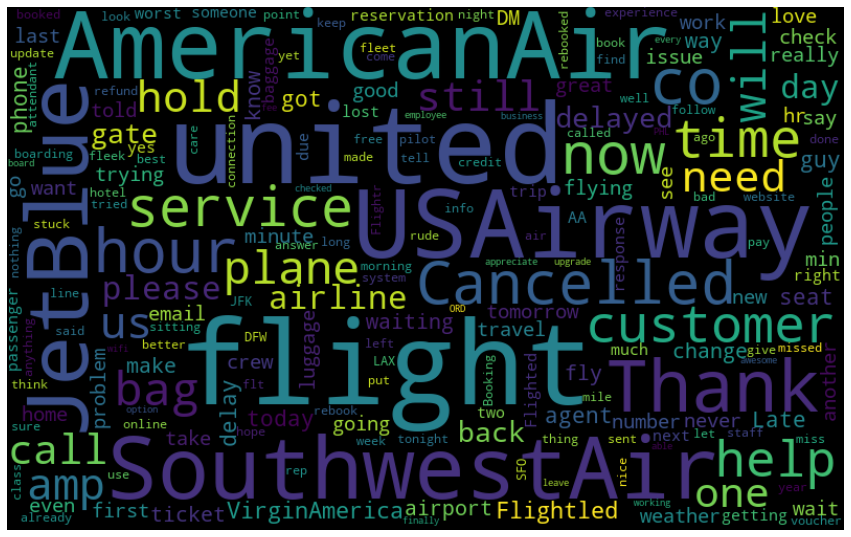

In [30]:
make_wcd(df)

Let's see the word clouds of differnt sentiments one by one.

# Postive Sentiment Word Cloud

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


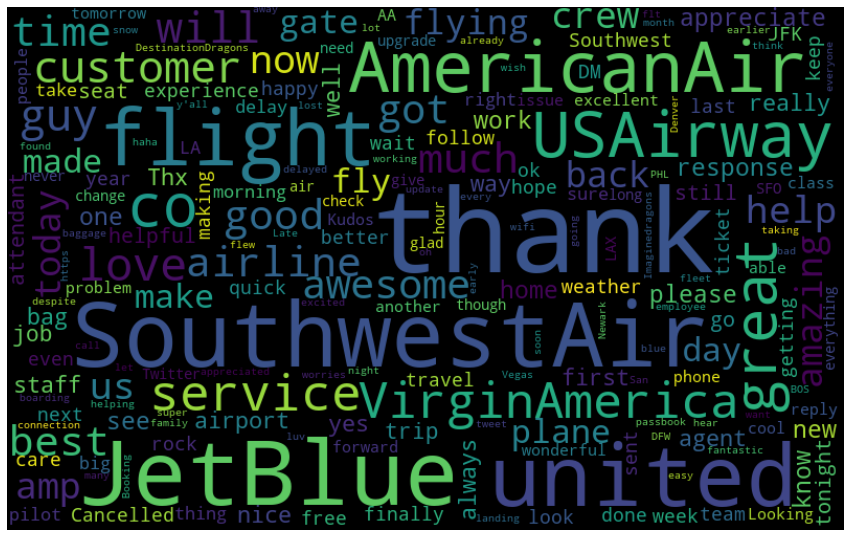

In [31]:
make_wcd(df[df['airline_sentiment']== 'positive'])

# Negative Sentiment Word Cloud

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


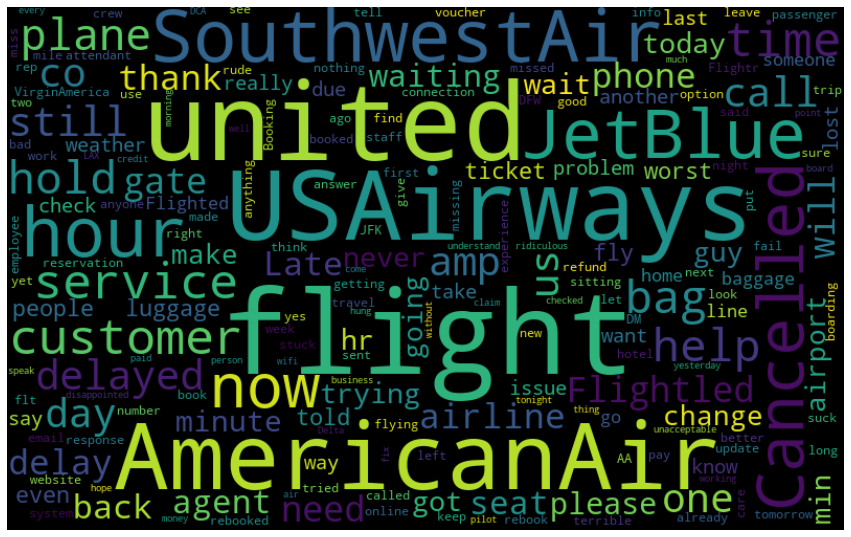

In [32]:
make_wcd(df[df['airline_sentiment']== 'negative'])

# Neutral Sentiment Word Cloud

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


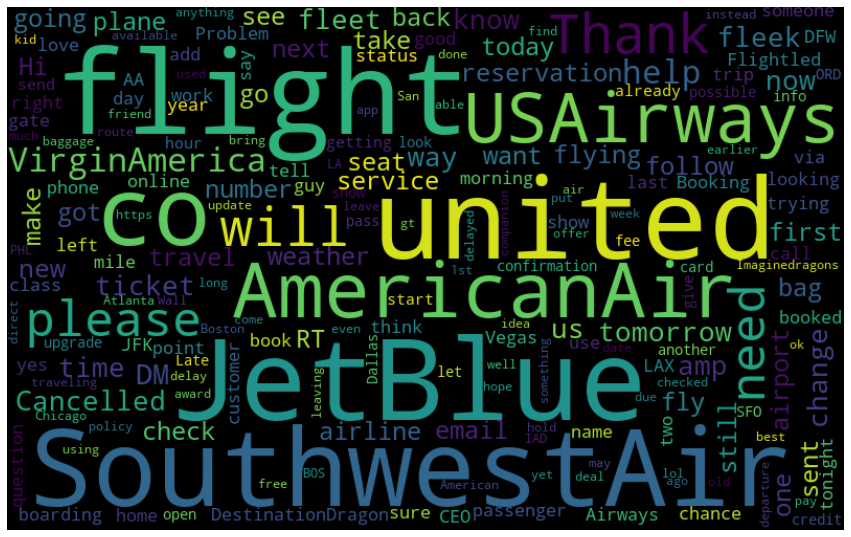

In [33]:
make_wcd(df[df['airline_sentiment']== 'neutral'])